# Healthy and Unhealthy Cities in America

### Business Problem
You're working for a health organization that wants to improve American's health and well being. Staying healthy and fit has been the latest craze among many Americans thanks to many social media influencers promoting healthy eating and fitness routines but yet Americans still struggle to stay healthy. It seems as though there is a correlation between your health and the city that you live in. Your organization wants to find out what differentiates cities with the healthiest population to cities with the unhealthiest population so your organization can suggest cities what they can do to improve the city's health and well being.<br>
We will be comparing cities with the healthiest population per capita to cities with the unhealthiest population per capita to find the key differences that differentiaties the cities. Comparing the number of healthy food options and the number of fitness facilities to cities that are ranked as the healthiest cities in America, I can provide insights that will suggest which health related venues a city needs to improve on so that we can potentially help cities that ranked as the unhealthiest cities in America to one day become one of the healthiest cities in America.

### Data and Data Sources
We will be comparing cities that ranked as the healthiest cities in America to cities that ranked as the unhealthiest cities in America. The <a href="https://wallethub.com">WalletHub</a> has ranked 170 cities in America in their <a href="https://wallethub.com/edu/healthiest-cities/31072">Healthiest and Unhealthiest Cities in America</a> report. We will be looking at the top 10 healthiest cities in America and the top 10 unhealthiest cities in America. <br>
We will then look at Foursquare API's venues data for the 20 cities. The venues data that we are interested in are healthy food providers such as restaurants and markets. We are also interested in fitness facilities such as gyms and recreation centers.

In [59]:
# Import and download all necessary libraries for this notebook
import pandas as pd
import numpy as np
import requests

from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim

! pip install folium==0.5.0
import folium
from folium import Circle, Marker

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


#### Data from WalletHub
<hr>
Here, we will scrape 170 cities that were ranked from healthiest to the least healthiest cities in America from <a href="https://wallethub.com">WalletHub</a>'s report about <a href="https://wallethub.com/edu/healthiest-cities/31072">Healthiest and Unhealthiest Cities in America</a> article.

In [2]:
# Open url to scrape table data from website
url = "https://wallethub.com/edu/healthiest-cities/31072"
hdr = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.104 Safari/537.36'}
req = Request(url, headers=hdr)
html = urlopen(req).read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")

In [3]:
table = soup.find_all("table")[0]
print(table)

<table class="cardhub-edu-table center-aligned sortable" style="width: 680px">
<thead>
<tr>
<th class="rank-numeric">
<p><b>Overall Rank</b></p>
</th>
<th>
<p><b>City</b></p>
</th>
<th class="rank-numeric">
<p><b>Total Score</b></p>
</th>
<th class="rank-numeric">
<p><b>Health Care</b></p>
</th>
<th class="rank-numeric">
<p><b>Food</b></p>
</th>
<th class="rank-numeric">
<p><b>Fitness</b></p>
</th>
<th class="rank-numeric">
<p><b>Green Space</b></p>
</th>
</tr>
</thead>
<tbody><tr><td>1</td><td>San Francisco, CA</td><td>69.11</td><td>10</td><td>1</td><td>59</td><td>1</td></tr><tr><td>2</td><td>Seattle, WA</td><td>65.70</td><td>14</td><td>6</td><td>25</td><td>2</td></tr><tr><td>3</td><td>Portland, OR</td><td>65.59</td><td>20</td><td>3</td><td>24</td><td>4</td></tr><tr><td>4</td><td>San Diego, CA</td><td>62.88</td><td>26</td><td>4</td><td>11</td><td>9</td></tr><tr><td>5</td><td>Honolulu, HI</td><td>62.75</td><td>12</td><td>11</td><td>57</td><td>5</td></tr><tr><td>6</td><td>Washington, DC

In [4]:
# Put scraped data into pandas dataframe
num_rows = 0
column_names = []

# count numbers of rows in table
for row in table.find_all('tr'):
    num_td = row.find_all('td')
    if len(num_td) > 0:
        num_rows += 1

# get headers of the table
num_th = table.find_all('th')
if len(num_th) > 0:
    for th in num_th:
        column_names.append(th.get_text(strip=True))
    
# create pandas dataframe with header names and include all rows in the table
df = pd.DataFrame(columns=column_names,index=range(0,num_rows))

row_position = 0
for row in table.find_all('tr'):
    column_position = 0
    columns = row.find_all('td')
    for column in columns:
        df.iat[row_position,column_position] = column.get_text(strip=True)
        column_position += 1
    if len(columns) > 0:
        row_position += 1

df

,Overall Rank,City,Total Score,Health Care,Food,Fitness,Green Space
0,1,"San Francisco, CA",69.11,10,1,59,1
1,2,"Seattle, WA",65.70,14,6,25,2
2,3,"Portland, OR",65.59,20,3,24,4
3,4,"San Diego, CA",62.88,26,4,11,9
4,5,"Honolulu, HI",62.75,12,11,57,5
...,...,...,...,...,...,...,...
177,178,"Memphis, TN",29.17,178,164,176,171
178,179,"Shreveport, LA",28.02,176,180,178,170
179,180,"Gulfport, MS",26.02,163,179,180,182
180,181,"Laredo, TX",25.64,181,181,182,157


In [5]:
# Clean the data by removing columns that are unnecessary for this analysis
df.columns = df.columns.str.replace('‘','').str.replace('’', '')
df.drop(['Overall Rank', 'Total Score', 'Health Care', 'Food', 'Fitness', 'Green Space'], axis=1, inplace=True)
df

,City
0,"San Francisco, CA"
1,"Seattle, WA"
2,"Portland, OR"
3,"San Diego, CA"
4,"Honolulu, HI"
...,...
177,"Memphis, TN"
178,"Shreveport, LA"
179,"Gulfport, MS"
180,"Laredo, TX"


In [6]:
# Extract top 10 healthiest cities
df_healthiest_cities = df.head(50).copy()
df_healthiest_cities.reset_index(drop=True, inplace=True)
df_healthiest_cities

,City
0,"San Francisco, CA"
1,"Seattle, WA"
2,"Portland, OR"
3,"San Diego, CA"
4,"Honolulu, HI"
5,"Washington, DC"
6,"Austin, TX"
7,"Irvine, CA"
8,"Portland, ME"
9,"Denver, CO"


In [7]:
# Extract top 10 unhealthiest cities
df_unhealthiest_cities = df.tail(50).copy()
df_unhealthiest_cities.reset_index(drop=True, inplace=True)
#df_unhealthiest_cities.sort_values(ascending=False)
df_unhealthiest_cities

,City
0,"Indianapolis, IN"
1,"Lewiston, ME"
2,"Little Rock, AR"
3,"Arlington, TX"
4,"El Paso, TX"
5,"Chattanooga, TN"
6,"Louisville, KY"
7,"Casper, WY"
8,"Oklahoma City, OK"
9,"Nampa, ID"


In [8]:
# Find latitude and longitude of all the ranked cities and append to the dataframe
latitude = []
longitude = []

for address in df_healthiest_cities['City']:
    geolocator = Nominatim(user_agent="healthiest_city_explorer")
    location = geolocator.geocode(address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)

df_healthiest_cities['Latitude'] = latitude
df_healthiest_cities['Longitude'] = longitude
df_healthiest_cities

,City,Latitude,Longitude
0,"San Francisco, CA",37.779026,-122.419906
1,"Seattle, WA",47.603832,-122.330062
2,"Portland, OR",45.520247,-122.674195
3,"San Diego, CA",32.717420,-117.162773
4,"Honolulu, HI",21.304547,-157.855676
5,"Washington, DC",38.894992,-77.036558
6,"Austin, TX",30.271129,-97.743700
7,"Irvine, CA",33.685697,-117.825982
8,"Portland, ME",43.661028,-70.254860
9,"Denver, CO",5.342848,-72.395985


In [9]:
latitude = []
longitude = []

for address in df_unhealthiest_cities['City']:
    geolocator = Nominatim(user_agent="unhealthiest_city_explorer")
    location = geolocator.geocode(address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    
df_unhealthiest_cities['Latitude'] = latitude
df_unhealthiest_cities['Longitude'] = longitude
df_unhealthiest_cities

,City,Latitude,Longitude
0,"Indianapolis, IN",39.916401,-86.051957
1,"Lewiston, ME",44.100351,-70.214776
2,"Little Rock, AR",34.746481,-92.289595
3,"Arlington, TX",32.701939,-97.105624
4,"El Paso, TX",31.775415,-106.464634
5,"Chattanooga, TN",35.045722,-85.309488
6,"Louisville, KY",38.254238,-85.759407
7,"Casper, WY",42.849709,-106.325493
8,"Oklahoma City, OK",35.472989,-97.517054
9,"Nampa, ID",43.573736,-116.559631


In [10]:
us_address = "USA"
geolocator = Nominatim(user_agent="us_explorer")
location = geolocator.geocode(address)
us_latitude = location.latitude
us_longitude = location.longitude

# Map all points of the top 10 healthiest cities on a folium map
# Light blue markers indicate healthiest cities
map_cities = folium.Map(location=[us_latitude,us_longitude], zoom_start=5)

for lat, lon, city in zip(df_healthiest_cities['Latitude'], df_healthiest_cities['Longitude'], df_healthiest_cities['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat,lon],
                  popup=label,
                  icon=folium.Icon(color="lightblue", icon="info", prefix="fa"),
                 ).add_to(map_cities)

# Map all points of the top 10 unhealthiest cities on a folium map
# Light gray markers indicate unhealthiest cities
for lat, lon, city in zip(df_unhealthiest_cities['Latitude'], df_unhealthiest_cities['Longitude'], df_unhealthiest_cities['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat,lon],
                  popup=label,
                  icon=folium.Icon(color="lightgray", icon="info", prefix="fa"),
                 ).add_to(map_cities)
    
map_cities

#### Data from Foursquare API
<hr>
Here, we will be retrieving venue data for all ranked cities from Foursquare API.

In [11]:
# The code was removed by Watson Studio for sharing.

In [12]:
# Define function to retrieve nearby venues for all ranked cities
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# Get venue categories for top 50 healthiest cities
df_healthiest_venues = getNearbyVenues(names=df_healthiest_cities['City'],latitudes=df_healthiest_cities['Latitude'],longitudes=df_healthiest_cities['Longitude'])

San Francisco, CA
Seattle, WA
Portland, OR
San Diego, CA
Honolulu, HI
Washington, DC
Austin, TX
Irvine, CA
Portland, ME
Denver, CO
South Burlington, VT
Burlington, VT
Huntington Beach, CA
Fremont, CA
Minneapolis, MN
Salt Lake City, UT
Scottsdale, AZ
Orlando, FL
Boston, MA
Boise, ID
San Jose, CA
Atlanta, GA
Santa Rosa, CA
Virginia Beach, VA
New York, NY
Madison, WI
Chicago, IL
Columbia, MD
Los Angeles, CA
Glendale, CA
Santa Clarita, CA
Fort Lauderdale, FL
Oakland, CA
Sacramento, CA
Richmond, VA
Plano, TX
Tampa, FL
Oceanside, CA
Miami, FL
Long Beach, CA
Raleigh, NC
Pittsburgh, PA
Lincoln, NE
Vancouver, WA
Tempe, AZ
Anaheim, CA
Chesapeake, VA
Nashua, NH
Rochester, NY
Missoula, MT


In [14]:
print(df_healthiest_venues.shape)
df_healthiest_venues.head()

(2484, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"San Francisco, CA",37.779026,-122.419906,Louise M. Davies Symphony Hall,37.777976,-122.420157,Concert Hall
1,"San Francisco, CA",37.779026,-122.419906,Herbst Theater,37.779548,-122.420953,Concert Hall
2,"San Francisco, CA",37.779026,-122.419906,War Memorial Opera House,37.778601,-122.420816,Opera House
3,"San Francisco, CA",37.779026,-122.419906,San Francisco Ballet,37.778580,-122.420798,Dance Studio
4,"San Francisco, CA",37.779026,-122.419906,Main Stage Of Davies Symphony Hall,37.777703,-122.420476,Performing Arts Venue


Here, we look at unique venue categories that can be associated with health and fitness.
<hr>
<strong>Health</strong>: Vegetarian / Vegan Restaurant, Doctor's Office, Pharmacy, Salad Place, Health Food Store, Supplement Shop, Medical Center, Farmers Market, Grocery Store, Supermarket, Organic Grocery, Fruit & Vegetable Store<br>
<strong>Fitness</strong>: Gym / Fitness Center, Gym, Sports Club, Skating Rink, Tennis Court, Athletics & Sports, Basketball Court, Hockey Field, Baseball Field, Climbing Gym, Recreation Center, Bike Rental / Bike Share, Yoga Studio

In [15]:
# Look at all the venue categories available
df_healthiest_venues['Venue Category'].unique()

array(['Concert Hall', 'Opera House', 'Dance Studio',
       'Performing Arts Venue', 'Park', 'Poke Place',
       'Furniture / Home Store', 'Boutique', 'Theater', 'Art Museum',
       'Jazz Club', 'Vietnamese Restaurant', 'Ramen Restaurant',
       'Tiki Bar', 'Beer Bar', 'Sushi Restaurant', "Men's Store",
       'Wine Shop', 'Bookstore', 'French Restaurant', 'Café', 'Bakery',
       'Wine Bar', 'Rock Club', 'Coffee Shop',
       'Vegetarian / Vegan Restaurant', 'Cocktail Bar', 'Music Venue',
       'Thai Restaurant', 'Indie Movie Theater', 'Food & Drink Shop',
       'Pedestrian Plaza', 'Italian Restaurant', 'Butcher',
       'Chocolate Shop', 'Juice Bar', 'Restaurant', 'Donut Shop',
       'Southern / Soul Food Restaurant', 'Gym / Fitness Center',
       'American Restaurant', 'Dumpling Restaurant', 'Comic Shop',
       'New American Restaurant', 'Ice Cream Shop', 'Plaza',
       'Event Space', 'Bagel Shop', 'Pizza Place', 'Sandwich Place',
       'Mexican Restaurant', 'Optical Shop

In [16]:
# Drop all venue categories that's not related health and fitness
index_healthiest = df_healthiest_venues[~(df_healthiest_venues['Venue Category'] == 'Vegetarian / Vegan Restaurant') & ~(df_healthiest_venues['Venue Category'] == 'Doctor\'s Office') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Pharmcy') & ~(df_healthiest_venues['Venue Category'] == 'Salad Place') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Health Food Store') & ~(df_healthiest_venues['Venue Category'] == 'Supplement Shop') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Medical Center') & ~(df_healthiest_venues['Venue Category'] == 'Farmers Market') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Grocery Store') & ~(df_healthiest_venues['Venue Category'] == 'Supermarket') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Organic Grocery') & ~(df_healthiest_venues['Venue Category'] == 'Fruit & Vegetable Store') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Gym / Fitness Center') & ~(df_healthiest_venues['Venue Category'] == 'Gym') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Sports Club') & ~(df_healthiest_venues['Venue Category'] == 'Skating Rink') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Tennis Court') & ~(df_healthiest_venues['Venue Category'] == 'Athletics & Sports') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Baksetball Court') & ~(df_healthiest_venues['Venue Category'] == 'Hockey Field') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Baseball Field') & ~(df_healthiest_venues['Venue Category'] == 'Climbing Gym') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Recreation Center') & ~(df_healthiest_venues['Venue Category'] == 'Bike Rental / Bike Share') 
                                        & ~(df_healthiest_venues['Venue Category'] == 'Yoga Studio')].index

df_healthiest_venues.drop(index_healthiest, inplace=True)

In [17]:
print(df_healthiest_venues.shape)
df_healthiest_venues.reset_index(drop=True)
df_healthiest_venues

(108, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
26,"San Francisco, CA",37.779026,-122.419906,Ananda Fuara,37.777693,-122.416353,Vegetarian / Vegan Restaurant
50,"San Francisco, CA",37.779026,-122.419906,Fitness SF,37.776161,-122.416413,Gym / Fitness Center
72,"San Francisco, CA",37.779026,-122.419906,Live Fit Gym,37.775928,-122.422939,Gym
84,"San Francisco, CA",37.779026,-122.419906,Thai Idea Vegetarian Restaurant,37.783395,-122.419141,Vegetarian / Vegan Restaurant
122,"Seattle, WA",47.603832,-122.330062,Cocoa Banana,47.602906,-122.333728,Salad Place
...,...,...,...,...,...,...,...
2368,"Chesapeake, VA",36.718371,-76.246680,Farmer's Market,36.720648,-76.242076,Farmers Market
2393,"Nashua, NH",42.765625,-71.467703,Open Space Yoga,42.761520,-71.466462,Yoga Studio
2424,"Rochester, NY",43.157285,-77.615214,Frozen Frontier,43.158495,-77.620081,Hockey Field
2478,"Missoula, MT",46.870105,-113.995267,Caras Park Farmers Market,46.869354,-113.996446,Farmers Market


In [18]:
# Get venue categories for top 50 unhealthiest cities
df_unhealthiest_venues = getNearbyVenues(names=df_unhealthiest_cities['City'],latitudes=df_unhealthiest_cities['Latitude'],longitudes=df_unhealthiest_cities['Longitude'])

Indianapolis, IN
Lewiston, ME
Little Rock, AR
Arlington, TX
El Paso, TX
Chattanooga, TN
Louisville, KY
Casper, WY
Oklahoma City, OK
Nampa, ID
Irving, TX
Akron, OH
Bakersfield, CA
Newark, NJ
Ontario, CA
Hialeah, FL
Fontana, CA
Tulsa, OK
Garland, TX
Stockton, CA
Fort Wayne, IN
Birmingham, AL
Grand Prairie, TX
Dover, DE
Columbus, GA
Moreno Valley, CA
Winston-Salem, NC
San Bernardino, CA
Charleston, WV
Amarillo, TX
Fayetteville, NC
Las Cruces, NM
Wichita, KS
North Las Vegas, NV
Mobile, AL
Baton Rouge, LA
Corpus Christi, TX
Detroit, MI
Augusta, GA
Toledo, OH
Lubbock, TX
Huntington, WV
Jackson, MS
Fort Smith, AR
Montgomery, AL
Memphis, TN
Shreveport, LA
Gulfport, MS
Laredo, TX
Brownsville, TX


In [19]:
print(df_unhealthiest_venues.shape)
df_unhealthiest_venues.head()

(1263, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Indianapolis, IN",39.916401,-86.051957,Sahm Golf Course,39.916499,-86.052166,Golf Course
1,"Indianapolis, IN",39.916401,-86.051957,Sahm Park,39.915540,-86.056717,Park
2,"Indianapolis, IN",39.916401,-86.051957,Sahm Aquatic Center,39.916161,-86.053200,Water Park
3,"Indianapolis, IN",39.916401,-86.051957,Sahm Park Playground,39.916161,-86.053200,Playground
4,"Indianapolis, IN",39.916401,-86.051957,Sahm Park Basketball,39.919759,-86.053497,Basketball Court


In [20]:
# Drop venue categories that's not related to health and fitness
index_unhealthiest = df_unhealthiest_venues[~(df_unhealthiest_venues['Venue Category'] == 'Vegetarian / Vegan Restaurant') & ~(df_unhealthiest_venues['Venue Category'] == 'Doctor\'s Office') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Pharmcy') & ~(df_unhealthiest_venues['Venue Category'] == 'Salad Place') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Health Food Store') & ~(df_unhealthiest_venues['Venue Category'] == 'Supplement Shop') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Medical Center') & ~(df_unhealthiest_venues['Venue Category'] == 'Farmers Market') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Grocery Store') & ~(df_unhealthiest_venues['Venue Category'] == 'Supermarket') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Organic Grocery') & ~(df_unhealthiest_venues['Venue Category'] == 'Fruit & Vegetable Store') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Gym / Fitness Center') & ~(df_unhealthiest_venues['Venue Category'] == 'Gym') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Sports Club') & ~(df_unhealthiest_venues['Venue Category'] == 'Skating Rink') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Tennis Court') & ~(df_unhealthiest_venues['Venue Category'] == 'Athletics & Sports') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Baksetball Court') & ~(df_unhealthiest_venues['Venue Category'] == 'Hockey Field') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Baseball Field') & ~(df_unhealthiest_venues['Venue Category'] == 'Climbing Gym') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Recreation Center') & ~(df_unhealthiest_venues['Venue Category'] == 'Bike Rental / Bike Share') 
                                        & ~(df_unhealthiest_venues['Venue Category'] == 'Yoga Studio')].index

df_unhealthiest_venues.drop(index_unhealthiest, inplace=True)

In [21]:
print(df_unhealthiest_venues.shape)
df_unhealthiest_venues.reset_index(drop=True)
df_unhealthiest_venues.head()

(48, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
19,"Little Rock, AR",34.746481,-92.289595,Snap Fitness,34.746102,-92.286690,Gym
123,"Louisville, KY",38.254238,-85.759407,Omni Fitness Center,38.252033,-85.754875,Gym / Fitness Center
161,"Oklahoma City, OK",35.472989,-97.517054,YMCA,35.472348,-97.513153,Gym
162,"Oklahoma City, OK",35.472989,-97.517054,Balance. Yoga. Barre.,35.476449,-97.514278,Yoga Studio
164,"Oklahoma City, OK",35.472989,-97.517054,Four star fitness - Downtown,35.476469,-97.514341,Gym


In [22]:
# Create a new dataframe for venue category
healthiest_cities_dummy = pd.get_dummies(df_healthiest_venues[['Venue Category']], prefix="", prefix_sep="")

healthiest_cities_dummy.insert(0, "City", df_healthiest_venues['City'])

print(healthiest_cities_dummy.shape)
healthiest_cities_dummy.head()

(108, 20)


,City,Athletics & Sports,Baseball Field,Farmers Market,Fruit & Vegetable Store,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,Hockey Field,Medical Center,Organic Grocery,Salad Place,Skating Rink,Sports Club,Supermarket,Supplement Shop,Tennis Court,Vegetarian / Vegan Restaurant,Yoga Studio
26,"San Francisco, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
50,"San Francisco, CA",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
72,"San Francisco, CA",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
84,"San Francisco, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
122,"Seattle, WA",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [26]:
# Get count for each category
healthiest_cities_grouped = healthiest_cities_dummy.groupby('City').size().reset_index(name='Total')
healthiest_cities_grouped

,City,Total
0,"Anaheim, CA",4
1,"Austin, TX",2
2,"Boise, ID",3
3,"Boston, MA",7
4,"Burlington, VT",8
5,"Chesapeake, VA",1
6,"Chicago, IL",4
7,"Fremont, CA",2
8,"Glendale, CA",4
9,"Huntington Beach, CA",1


In [24]:
# Create a new dataframe for venue category
unhealthiest_cities_dummy = pd.get_dummies(df_unhealthiest_venues[['Venue Category']], prefix="", prefix_sep="")

unhealthiest_cities_dummy.insert(0, "City", df_unhealthiest_venues['City'])

print(unhealthiest_cities_dummy.shape)
unhealthiest_cities_dummy.head()

(48, 11)


,City,Baseball Field,Doctor's Office,Farmers Market,Grocery Store,Gym,Gym / Fitness Center,Salad Place,Skating Rink,Supermarket,Yoga Studio
19,"Little Rock, AR",0,0,0,0,1,0,0,0,0,0
123,"Louisville, KY",0,0,0,0,0,1,0,0,0,0
161,"Oklahoma City, OK",0,0,0,0,1,0,0,0,0,0
162,"Oklahoma City, OK",0,0,0,0,0,0,0,0,0,1
164,"Oklahoma City, OK",0,0,0,0,1,0,0,0,0,0


In [25]:
# Get count for each category
unhealthiest_cities_grouped = unhealthiest_cities_dummy.groupby('City').size().reset_index(name='Total')
unhealthiest_cities_grouped

,City,Total
0,"Augusta, GA",1
1,"Bakersfield, CA",1
2,"Birmingham, AL",3
3,"Charleston, WV",3
4,"Detroit, MI",4
5,"Fayetteville, NC",2
6,"Fontana, CA",1
7,"Fort Smith, AR",1
8,"Fort Wayne, IN",3
9,"Grand Prairie, TX",1


In [32]:
healthiest_cities_numbers = healthiest_cities_grouped.drop(['City'], 1)

import matplotlib.pyplot as plt

wss = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(healthiest_cities_numbers)
    wss.append(km.inertia_)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:9: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:9: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (11). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:9: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (12). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:9: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (13). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:9: ConvergenceWarning: Number of distinct clusters (9) found smaller t

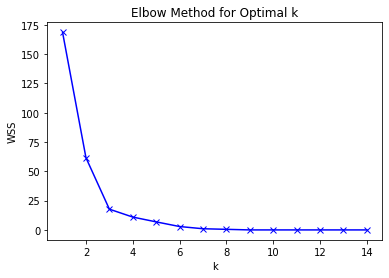

In [33]:
plt.plot(K, wss, 'bx-')
plt.xlabel('k')
plt.ylabel('WSS')
plt.title('Elbow Method for Optimal k')
plt.show()

In [40]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(healthiest_cities_numbers)

# add clustering labels
healthiest_cities_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

healthiest_cities_merged = df_healthiest_venues

# merge downtown_toronto_merged with downtown_toronto to add latitude/longitude for each neighborhood
healthiest_cities_merged = healthiest_cities_merged.join(healthiest_cities_grouped.set_index('City'), on='City')

healthiest_cities_merged.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Total
26,"San Francisco, CA",37.779026,-122.419906,Ananda Fuara,37.777693,-122.416353,Vegetarian / Vegan Restaurant,0,4
50,"San Francisco, CA",37.779026,-122.419906,Fitness SF,37.776161,-122.416413,Gym / Fitness Center,0,4
72,"San Francisco, CA",37.779026,-122.419906,Live Fit Gym,37.775928,-122.422939,Gym,0,4
84,"San Francisco, CA",37.779026,-122.419906,Thai Idea Vegetarian Restaurant,37.783395,-122.419141,Vegetarian / Vegan Restaurant,0,4
122,"Seattle, WA",47.603832,-122.330062,Cocoa Banana,47.602906,-122.333728,Salad Place,0,4


In [64]:
unhealthiest_cities_numbers = unhealthiest_cities_grouped.drop(['City'], 1)

wss = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(unhealthiest_cities_numbers)
    wss.append(km.inertia_)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: ConvergenceWarning: Number of distinct clusters (4) found smaller than 

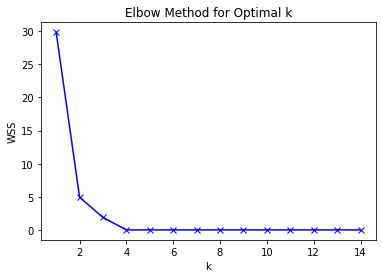

In [65]:
plt.plot(K, wss, 'bx-')
plt.xlabel('k')
plt.ylabel('WSS')
plt.title('Elbow Method for Optimal k')
plt.show()

In [71]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(unhealthiest_cities_numbers)

# add clustering labels
#unhealthiest_cities_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

unhealthiest_cities_merged = df_unhealthiest_venues

# merge downtown_toronto_merged with downtown_toronto to add latitude/longitude for each neighborhood
unhealthiest_cities_merged = unhealthiest_cities_merged.join(unhealthiest_cities_grouped.set_index('City'), on='City')

unhealthiest_cities_merged.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Total
19,"Little Rock, AR",34.746481,-92.289595,Snap Fitness,34.746102,-92.286690,Gym,0,1
123,"Louisville, KY",38.254238,-85.759407,Omni Fitness Center,38.252033,-85.754875,Gym / Fitness Center,0,1
161,"Oklahoma City, OK",35.472989,-97.517054,YMCA,35.472348,-97.513153,Gym,1,4
162,"Oklahoma City, OK",35.472989,-97.517054,Balance. Yoga. Barre.,35.476449,-97.514278,Yoga Studio,1,4
164,"Oklahoma City, OK",35.472989,-97.517054,Four star fitness - Downtown,35.476469,-97.514341,Gym,1,4


In [77]:
# create map
cities_clusters = folium.Map(location=[us_latitude, us_longitude], zoom_start=5)

# add markers to the map
for i in range(0,len(healthiest_cities_merged)):
   Circle(
      location=[int(healthiest_cities_merged.iloc[i]['City Latitude']), int(healthiest_cities_merged.iloc[i]['City Longitude'])],
      popup=healthiest_cities_merged.iloc[i]['City'],
      radius=int(healthiest_cities_merged.iloc[i]['Total']*10000),
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(cities_clusters)

for i in range(0,len(unhealthiest_cities_merged)):
   Circle(
      location=[int(unhealthiest_cities_merged.iloc[i]['City Latitude']), int(unhealthiest_cities_merged.iloc[i]['City Longitude'])],
      popup=unhealthiest_cities_merged.iloc[i]['City'],
      radius=int(unhealthiest_cities_merged.iloc[i]['Total']*10000),
      color='gray',
      fill=True,
      fill_color='gray'
   ).add_to(cities_clusters)
       
cities_clusters.save('cities_clusters.html')
cities_clusters